In [1]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

## 2.2 Action-Value Methods

### $\epsilon$-greedy method

In [4]:
num_A = 10
num_tasks = 1_000
num_episodes = 2_000
reward_mean = 0.5
reward_variance = 1

In [11]:
def run_episode(eps):
    reward_dist = np.random.normal(reward_mean, reward_variance, size=num_A)
    action_value_estimates = np.zeros(num_A, dtype=np.float32)
    action_chosen_counts = np.zeros(num_A)
    reward_history = []
    for play in range(1, num_tasks+1):
        if random.random() < eps:
            a_t = random.choice(range(0,num_A))
        else:
            a_t = np.argmax(action_value_estimates)
        r_t = random.gauss(reward_dist[a_t])
        reward_history.append(r_t)
        times_chosen = action_chosen_counts[a_t]
        action_value_estimates[a_t] = ((action_value_estimates[a_t] * times_chosen) + r_t) / (times_chosen + 1)
        action_chosen_counts[a_t] += 1
    return np.array(reward_history), reward_dist, action_value_estimates, action_chosen_counts

In [160]:
epsilons = [0, 0.1, 0.01]
reward_dict = {}
for eps in epsilons:
    print(f"Running task with eps={eps}")
    mean_history = np.zeros(num_tasks)
    for task in tqdm(range(num_episodes)):
        history, Q_star, Q_a, action_chosen_counts = run_episode(eps)
        mean_history += history
    mean_history /= num_episodes
    reward_dict[eps] = mean_history

Running task with eps=0


100%|██████████| 2000/2000 [00:09<00:00, 211.10it/s]


Running task with eps=0.1


100%|██████████| 2000/2000 [00:08<00:00, 242.69it/s]


Running task with eps=0.01


100%|██████████| 2000/2000 [00:09<00:00, 205.58it/s]


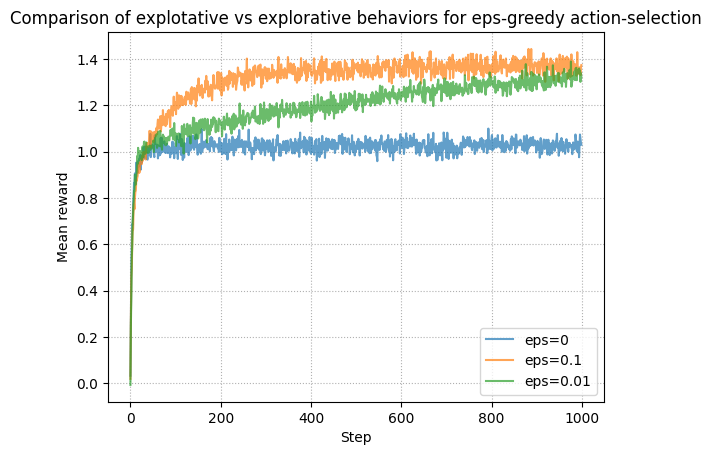

In [161]:
plt.figure()
for eps in epsilons:
    plt.plot(np.arange(1000), reward_dict[eps], label=f'eps={eps}', alpha=0.7)
plt.title("Comparison of explotative vs explorative behaviors for eps-greedy action-selection")
plt.xlabel("Step")
plt.ylabel("Mean reward")
plt.grid(linestyle=':')
plt.legend()
plt.show()

### Softmax Action-Selection

In [176]:
def softmax(x, tau=1.0):
    x = np.array(x)
    z = x / tau
    z = z - np.max(z)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z)

In [194]:
def run_episode(temperature, num_A):
    reward_dist = np.random.normal(reward_mean, reward_variance, size=num_A)
    action_value_estimates = np.zeros(num_A, dtype=np.float32)
    action_chosen_counts = np.zeros(num_A)
    reward_history = []
    for play in range(1, num_tasks+1):
        probs = softmax(action_value_estimates, tau=temperature)
        a_t = np.random.choice(len(action_value_estimates), p=probs)
        r_t = random.gauss(reward_dist[a_t])
        reward_history.append(r_t)
        times_chosen = action_chosen_counts[a_t]
        action_value_estimates[a_t] = ((action_value_estimates[a_t] * times_chosen) + r_t) / (times_chosen + 1)
        action_chosen_counts[a_t] += 1
    return np.array(reward_history), reward_dist, action_value_estimates, action_chosen_counts

In [195]:
temperatures = [0.1, 1, 2, 5]
reward_dict = {}
for temp in temperatures:
    print(f"Running task with temp={temp}")
    mean_history = np.zeros(num_tasks)
    for task in tqdm(range(num_episodes)):
        history, Q_star, Q_a, action_chosen_counts = run_episode(temp, num_A)
        mean_history += history
    mean_history /= num_episodes
    reward_dict[eps] = mean_history

Running task with temp=0.1


100%|██████████| 2000/2000 [02:22<00:00, 14.03it/s]


Running task with temp=1


100%|██████████| 2000/2000 [02:27<00:00, 13.58it/s]


Running task with temp=2


100%|██████████| 2000/2000 [02:31<00:00, 13.22it/s]


Running task with temp=5


100%|██████████| 2000/2000 [02:32<00:00, 13.07it/s]


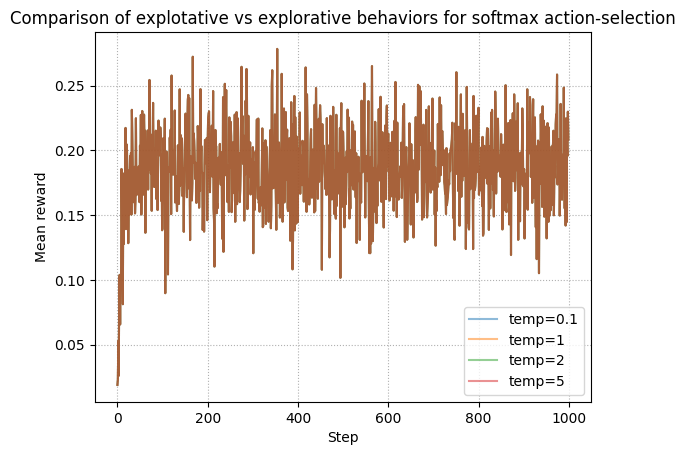

In [197]:
plt.figure()
for temp in temperatures:
    plt.plot(np.arange(1000), reward_dict[eps], label=f'temp={temp}', alpha=0.5)
plt.title("Comparison of explotative vs explorative behaviors for softmax action-selection")
plt.xlabel("Step")
plt.ylabel("Mean reward")
plt.grid(linestyle=':')
plt.legend()
plt.show()

In [189]:
probs = softmax(reward_dist, 2)
np.random.choice(10, p=probs)

9

In [190]:
sorted(probs, reverse=True)

[0.16951827456330015,
 0.14031395376302586,
 0.11952186655689447,
 0.11530058872278151,
 0.11344121333897193,
 0.10164409273764397,
 0.0880827631757272,
 0.06845073195734754,
 0.06455172054214285,
 0.01917479464216463]

## Non-Stationary Problems

### Sutton & Barto, Exercise 2.7 
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have on nonstationary problems. Use a modified version of the 10-armed testbed in which all the $Q^{*}(a)$ start out equal and then take independent random walks. Prepare  plots like Figure 2.1 for an action-value method using sample averages, incrementally computed by $\alpha=\frac{1}{k}$, and another action-value method using a constant step size, $\alpha=0.1$. Use ${\epsilon=.1}$ and, if necessary, runs longer than 1000 plays.

In [14]:
def run_episode(eps=0.1, with_alpha=True, alpha=0.1, num_tasks=1000):
    Q_star = np.random.normal(reward_mean, reward_variance, size=num_A) # true action values
    Q_est = np.zeros(num_A, dtype=np.float32) # estimated action values
    action_chosen_counts = np.zeros(num_A) # times action has been chosen
    reward_hist = [] # history of reward at each step
    for play in range(1, num_tasks+1):
        # non-stationary target simulation -> random walk on Q_star
        Q_star += np.random.normal(0, 0.01, size=num_A)
        if random.random() < eps:
            a_t = random.choice(range(0, num_A)) # action at t is explorative 
        else:
            a_t = np.argmax(Q_est) # action at t is exploitative
        r_t = random.gauss(Q_star[a_t]) # reward from true action value distribution
        reward_hist.append(r_t)
        k = action_chosen_counts[a_t] # times that action has been chosen
        if with_alpha:
            Q_est[a_t] += alpha * (r_t - Q_est[a_t]) # update with alpha
        else:
            Q_est[a_t] += (r_t - Q_est[a_t]) / (k+1) # update with avg
        action_chosen_counts[a_t] += 1
    return np.array(reward_hist), Q_star, Q_est, action_chosen_counts


In [17]:
eps = 0.1
histories = dict()
print(f"Running task with constant step-size alpha={0.1} & eps={eps}")
mean_history = np.zeros(num_tasks)
for task in tqdm(range(num_episodes)):
    history, Q_star, Q_a, action_chosen_counts = run_episode(eps, with_alpha=True)
    mean_history += history
mean_history /= num_episodes
histories['constant_step'] = mean_history

print(f"Running task with sample average step & eps={eps}")
mean_history = np.zeros(num_tasks)
for task in tqdm(range(num_episodes)):
    history, Q_star, Q_a, action_chosen_counts = run_episode(eps, with_alpha=False)
    mean_history += history
mean_history /= num_episodes
histories['sample_avg'] = mean_history

Running task with constant step-size alpha=0.1 & eps=0.1


100%|██████████| 2000/2000 [00:22<00:00, 90.85it/s] 


Running task with sample average step & eps=0.1


100%|██████████| 2000/2000 [00:18<00:00, 105.58it/s]


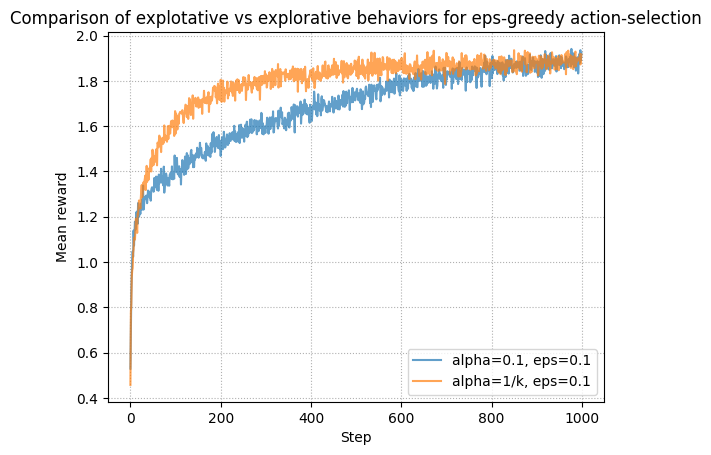

In [18]:
plt.figure()
plt.plot(np.arange(1000), histories['constant_step'], label=f'alpha=0.1, eps={eps}', alpha=0.7)
plt.plot(np.arange(1000), histories['sample_avg'], label=f'alpha=1/k, eps={eps}', alpha=0.7)
plt.title("Comparison of explotative vs explorative behaviors for eps-greedy action-selection")
plt.xlabel("Step")
plt.ylabel("Mean reward")
plt.grid(linestyle=':')
plt.legend()
plt.show()